Tim Smith

2019.09.21

# Control run Hovmöller plots 

## Showing zonal mean -vs- avg seasonal cycle for
- Precip
- P-E
- Surface temperature
- ...

In [12]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import glob
import dask.array as da
from copy import deepcopy

import cftime # for converting the netcdf time to something nice

In [13]:
data_dir = '/Users/tim/work/results/acdc/half_ocean_newbucket_0qflux_control'
globname = data_dir + '/*/*.nc'
file_list = glob.glob(globname)
file_list = sorted(file_list)
ds_ctrl = xr.open_mfdataset(file_list,autoclose='true')

lat = ds_ctrl['lat'].values[:]
lon = ds_ctrl['lon'].values[:]
lev = ds_ctrl['pfull'].values[:]

/Users/tim/anaconda3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/Users/tim/anaconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


### First, remove first 8 years of spinup and convert time units to something nice for xarray

In [33]:
with xr.set_options(enable_cftimeindex=True):
    ds_ctrl = xr.open_mfdataset(file_list,autoclose='true',decode_times=False)

time0 = ds_ctrl['time']
# time2 = nc.num2date(ds_ctrl['time'][:], units=ds_ctrl['time'].units,
#                             calendar=ds_ctrl['time'].calendar,only_use_cftime_datetimes=True)

time2 = cftime.num2date(ds_ctrl['time'][:], units=ds_ctrl['time'].units,
                            calendar=ds_ctrl['time'].calendar,only_use_cftime_datetimes=True)

ds_ctrl['time'].values = time2

# Drop everything before the 9th year
ds_ctrl = ds_ctrl.where(ds_ctrl['time'].dt.year.isin(range(9,11)),drop=True)

### Now, very easily lets compute the seasonal cycle for all fields

In [47]:
ds_clim = ds_ctrl.groupby('time.month').mean('time')

Text(0.5,1,'Zonal mean precipitation')

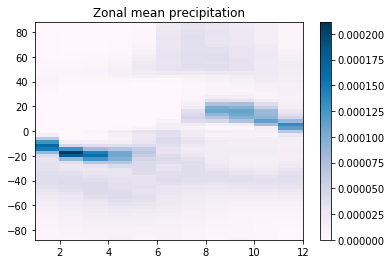

In [48]:
months = ds_clim['month']
plt.figure()
plt.pcolormesh(months,lat,ds_clim['precipitation'].mean('lon').T,cmap='PuBu')
plt.colorbar()
plt.title('Zonal mean precipitation')

Help on function pcolor in module matplotlib.pyplot:

pcolor(*args, **kwargs)
    Create a pseudocolor plot with a non-regular rectangular grid.
    
    Call signature::
    
        pcolor([X, Y,] C, **kwargs)
    
    *X* and *Y* can be used to specify the corners of the quadrilaterals.
    
    .. hint::
    
        ``pcolor()`` can be very slow for large arrays. In most
        cases you should use the the similar but much faster
        `~.Axes.pcolormesh` instead. See there for a discussion of the
        differences.
    
    Parameters
    ----------
    C : array_like
        A scalar 2-D array. The values will be color-mapped.
    
    X, Y : array_like, optional
        The coordinates of the quadrilateral corners. The quadrilateral
        for ``C[i,j]`` has corners at::
    
            (X[i+1, j], Y[i+1, j])          (X[i+1, j+1], Y[i+1, j+1])
                                  +--------+
                                  | C[i,j] |
                                  +---